## Project: Bike sharing prediction using machine learning
- **Source**: Hadi Fanaee-T, João Gama (2013). Event labeling combining ensemble detectors and background knowledge. DOI:10.1007/s13748-013-0040-3
- **URL**: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset
- **Date**: 29/11/24
- **Goal**: Create a basic prediction model and a feature explainer

In [15]:
# Step 0. Import libraries and custom modules
# Basics ---------------------------------------------------------------
import os
import logging
from zipfile import ZipFile
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning -----------------------------------------------------
from sklearn.ensemble import (
    RandomForestRegressor, 
    HistGradientBoostingRegressor
)
from sklearn.metrics import (
    mean_squared_error,
    mean_squared_log_error,
    mean_absolute_error,
    r2_score
)

# Timeseries -----------------------------------------------------------
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### 1. Data loading
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
# Step 1. Load the data
# 1.1 Retrieve data from source and get info
url = (
    'https://raw.githubusercontent.com/blobibob/' + 
    'bike-sharing-dataset/refs/heads/main/hour.csv'
)
df_raw = pd.read_csv(url)
display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


None

In [5]:
# 1.2 Show a sample
df_raw.sample(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
5276,5277,2011-08-12,3,0,8,18,0,5,1,1,0.76,0.6818,0.40,0.2985,89,376,465
10889,10890,2012-04-03,2,1,4,21,0,2,1,1,0.54,0.5152,0.45,0.0000,33,210,243
6661,6662,2011-10-10,4,0,10,3,1,1,0,1,0.46,0.4545,0.88,0.0000,2,9,11
12952,12953,2012-06-28,3,1,6,21,0,4,1,1,0.76,0.6970,0.55,0.1940,89,309,398
5752,5753,2011-09-02,3,0,9,3,0,5,1,2,0.60,0.5606,0.83,0.1642,4,4,8
4418,4419,2011-07-08,3,0,7,0,0,5,1,1,0.74,0.6970,0.66,0.1045,6,41,47
2819,2820,2011-05-02,2,0,5,9,0,1,1,2,0.50,0.4848,0.77,0.2836,41,131,172
3314,3315,2011-05-23,2,0,5,0,0,1,1,2,0.56,0.5303,0.88,0.1343,23,18,41
4491,4492,2011-07-11,3,0,7,1,0,1,1,1,0.70,0.6515,0.61,0.2836,5,5,10
15520,15521,2012-10-13,4,1,10,21,0,6,0,1,0.40,0.4091,0.58,0.1940,47,157,204


## **Data Dictionary**


|Variable Name| Role| Type| Description| Units| Missing Values|
|-------------|-----|-----|------------|------|---------------|
|instant|	ID|	Integer|	record index| |		no|
|dteday|	Feature|	Date|	date| |		no|
|season|	Feature|	Categorical|	1:winter, 2:spring, 3:summer, 4:fall| |		no|
|yr|	Feature|	Categorical|	year (0: 2011, 1: 2012)| |		no|
|mnth|	Feature|	Categorical|	month (1 to 12)| |		no|
|hr|	Feature|	Categorical|	hour (0 to 23)| |		no|
|holiday|	Feature|	Binary|	weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)|	|	no|
|weekday|	Feature|	Categorical|	day of the week| |		no|
|workingday|	Feature|	Binary|	if day is neither weekend nor holiday is 1, otherwise is 0|	|	no|
|weathersit|	Feature|	Categorical|	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy| |		no|
|temp|	Feature|	Continuous|	Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)|	C|	no|
|atemp|	Feature|	Continuous|	Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)|	C|	no|
|hum|	Feature|	Continuous|	Normalized humidity. The values are divided to 100 (max)|	|	no|
|windspeed|	Feature|	Continuous|	Normalized wind speed. The values are divided to 67 (max)|	|	no|
|casual|	Other|	Integer|	count of casual users|	|	no|
|registered|	Other|	Integer|	count of registered users| |		no|
|cnt|	Target|	Integer|	count of total rental bikes including both casual and registered|	|	no|

### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [7]:
df = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .drop_duplicates()
    .rename(columns={'cnt':'target'})
    .astype({'season':'category',
             'weathersit':'category',
             'holiday':'category',
             'weekday':'category',
             'workingday':'category',
             'dteday':'datetime64[ns]'})
  #  .assign(count_lagged_week = df_raw['cnt'].shift(24*7))
    .drop(['instant','yr','casual','registered'], axis=1)
    .set_index('dteday')
)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   mnth        17379 non-null  int64   
 2   hr          17379 non-null  int64   
 3   holiday     17379 non-null  category
 4   weekday     17379 non-null  category
 5   workingday  17379 non-null  category
 6   weathersit  17379 non-null  category
 7   temp        17379 non-null  float64 
 8   atemp       17379 non-null  float64 
 9   hum         17379 non-null  float64 
 10  windspeed   17379 non-null  float64 
 11  target      17379 non-null  int64   
dtypes: category(5), float64(4), int64(3)
memory usage: 1.1 MB


### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [9]:
# Step 3. EDA
# 3.1 Create train and test splits
X = df.drop('target', axis=1)
y = df['target']
horizon = 24*7
X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1)

In [ ]:
# 3.2 Show descriptive statistic
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
target,17211.0,190.583871,181.772948,1.00,41.0000,144.0000,282.0000,977.0000
mnth,17211.0,6.484458,3.412700,1.00,4.0000,6.0000,9.0000,12.0000
hr,17211.0,11.546046,6.914083,0.00,6.0000,12.0000,18.0000,23.0000
temp,17211.0,0.499377,0.191917,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17211.0,0.478057,0.171071,0.00,0.3333,0.4848,0.6212,1.0000
hum,17211.0,0.626905,0.193236,0.00,0.4700,0.6300,0.7800,1.0000
windspeed,17211.0,0.189703,0.122062,0.00,0.1045,0.1940,0.2537,0.8507


,count,unique,top,freq
season,17211,4,3,4496
holiday,17211,2,0,16734
weekday,17211,7,6,2488
workingday,17211,2,1,11768
weathersit,17211,4,1,11358


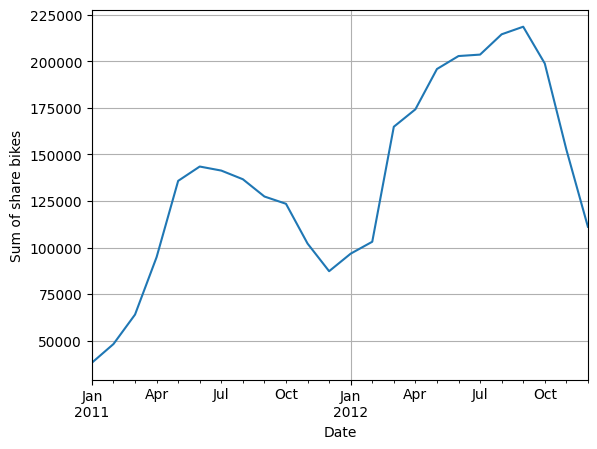

In [13]:
# 3.3 Show trend analysis
df_train['target'].resample("ME").sum().plot()
plt.xlabel("Date")
plt.ylabel("Sum of share bikes")
plt.grid(True)
plt.show()

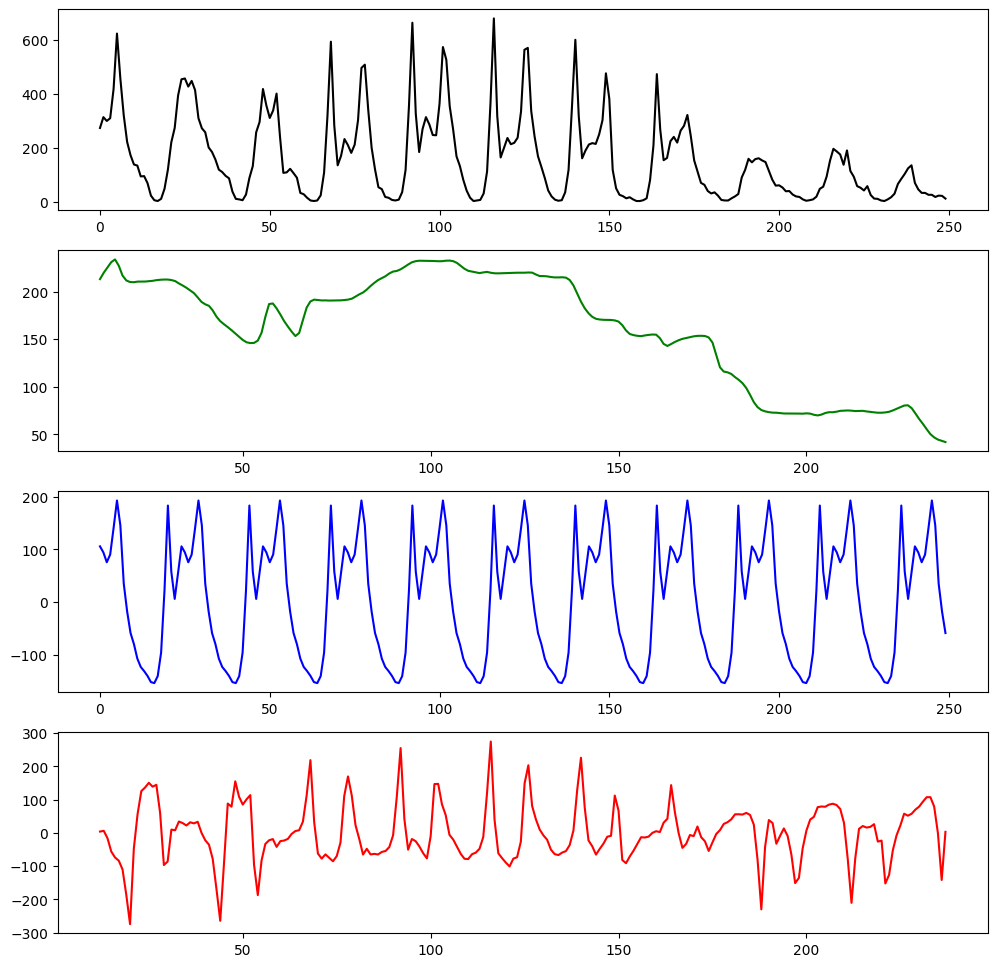

In [18]:
# 3.4 Create seasonal decomposition
data = seasonal_decompose(df_train['target'].values[-250:], period=24)
data_observed = data.observed
data_trend = data.trend
data_seasonal = data.seasonal
data_residual = data.resid

fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax[0].plot(data_observed, label='Observed', c='k')
ax[1].plot(data_trend, label="Trend", c='g')
ax[2].plot(data_seasonal, label="Seasonal", c='b')
ax[3].plot(data_residual, label="Residual", c='r')

plt.show()